In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tabulate import tabulate
import re
import seaborn as sns

# formatting
pd.options.display.float_format = '{:,}'.format
table_style = [{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana'),
            ("font-size", "90%")]},
 {'selector': 'td',
  'props': [('font-family', 'verdana'), 
            ("font-size", "90%"),
            ("font-weight", "bold")]},
 {'selector': 'tr:hover',
  'props': [('background-color', '#ffffcc')]}
]

bench = {'cut_sgemm-0':0, 'cut_sgemm-1':0, 'cut_wmma-0': 0, 'cut_wmma-1': 0, 
         'parb_stencil-0': 1, 'parb_sgemm-0': 0,
         'parb_lbm-0': 1, 'parb_spmv-0': 1, 'parb_cutcp-0': 0}

def color_CM(s):
    '''
    color compute intensive green and memory intensive red
    '''
    if bench[s['benchmark']] == 0:
        # compute intensive
        return ['color: #5fba7d' for v in s]
    else:
        return ['color: #d65f5f' for v in s]
    
def color_CM_pair(s):
    return ['color: #5fba7d' if bench[v] == 0 else 'color: #d65f5f' for v in s]

def avg_array(s):
    result = [np.average(np.array(v[1:-1].split(' ')).astype(float)) for v in s]
    return result

In [9]:
df_cutcp_intra = pd.read_csv('cutcp-intra.csv')
print(df_cutcp_intra.columns)
print(df_cutcp_intra['config'][0])

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'grid_x', 'grid_y',
       'grid_z', 'block_x', 'block_y', 'block_z', 'ctas/SM', 'runtime',
       'instructions', 'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core',
       'avg_mrq_latency', 'stall_core_ldst', 'stall_icnt_to_l2', 'l2_BW',
       'l2_rshr_entry_fail', 'l2_rshr_merge_fail', 'stall_l2_to_icnt',
       'l1D_miss_rate', 'l2_miss_rate', 'packet_lat_out', 'network_lat_out',
       'inject_out', 'accepted_out', 'packet_lat_in', 'network_lat_in',
       'inject_in', 'accepted_in', 'mem_subpartition_parallism',
       'mem_subpartition_parallism_util', 'L2_reservation_fail', 'dram_eff',
       'dram_bw', 'row_buffer_locality', 'mrqq', 'total_cmd', 'wasted_col',
       'wasted_row', 'mem_idle', 'CCDLc', 'WTRc', 'RTWc', 'RCDc', 'RCDWRc'],
      dtype='object')
TITANV-SEP_RW-CONCURRENT-INTRA_0:1:0_CTA-PARTITION_L2_0:0.5:0.5


                                              config    L2  CTA/SM
4  TITANV-SEP_RW-CONCURRENT-INTRA_0:1:0_CTA-PARTI...   1.0       1
1  TITANV-SEP_RW-CONCURRENT-INTRA_0:2:0_CTA-PARTI...   1.0       2
0  TITANV-SEP_RW-CONCURRENT-INTRA_0:1:0_CTA-PARTI...   0.5       1
5  TITANV-SEP_RW-CONCURRENT-INTRA_0:2:0_CTA-PARTI...   0.5       2
2  TITANV-SEP_RW-CONCURRENT-INTRA_0:1:0_CTA-PARTI...  0.25       1
6  TITANV-SEP_RW-CONCURRENT-INTRA_0:2:0_CTA-PARTI...  0.25       2
3  TITANV-SEP_RW-CONCURRENT-INTRA_0:1:0_CTA-PARTI... 0.125       1
7  TITANV-SEP_RW-CONCURRENT-INTRA_0:2:0_CTA-PARTI... 0.125       2


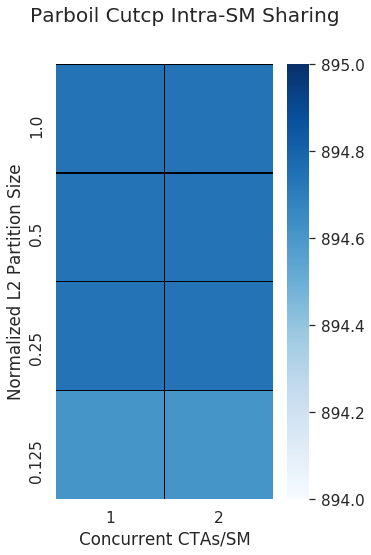

In [58]:
regex_cta = r'INTRA_0:(.*):0_CTA'
df_cutcp_intra['CTA/SM'] = df_cutcp_intra['config'].apply(lambda x: re.search(regex_cta, x).group(1)).astype(int)

regex_sm = r'PARTITION_L2_0:(.*):[0-9|\.]+'
df_cutcp_intra['L2'] = df_cutcp_intra['config'].apply(lambda x: re.search(regex_sm, x).group(1)).astype(float)
no_sm = len(df_cutcp_intra['SM'].unique())

df_cutcp_intra['IPC'] = df_cutcp_intra['instructions'] / df_cutcp_intra['runtime']

df_cutcp_intra.sort_values(['L2', 'CTA/SM'], inplace=True, ascending=[False, True])
print(df_cutcp_intra[['config', 'L2', 'CTA/SM']])
data = np.split(df_cutcp_intra['IPC'].values, no_sm)

mpl.style.use('seaborn-paper')
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(5,8))   
sns.heatmap(data, ax=ax, linewidth=0.2, linecolor='black', 
            square=True, cmap='Blues', vmin=894, vmax=895,
            xticklabels=df_cutcp_intra['CTA/SM'].unique(), yticklabels=df_cutcp_intra['L2'].unique(),
           )
fig.suptitle('Parboil Cutcp Intra-SM Sharing')
ax.set_xlabel('Concurrent CTAs/SM')
ax.set_ylabel('Normalized L2 Partition Size')
plt.show()


[[0.42473935 0.21831329 0.74778349 0.06005391 0.36655659 0.43954907
  0.90990884 0.68342877 0.57736975 0.27363412 0.43701834 0.6868038 ]
 [0.13389436 0.64116533 0.21678601 0.24353079 0.87152573 0.67035358
  0.15896559 0.45597896 0.80269841 0.78043869 0.4378558  0.70816646]
 [0.0357305  0.58240923 0.94888277 0.64023358 0.75464383 0.51479455
  0.38741588 0.25039188 0.3314381  0.01883002 0.90400743 0.23490373]
 [0.87996149 0.24673451 0.01914745 0.90663959 0.67221177 0.85721712
  0.85350247 0.15361354 0.6813133  0.74016067 0.73729273 0.3984182 ]
 [0.02019258 0.78764469 0.33696597 0.76065829 0.90124649 0.08502345
  0.76485719 0.21610052 0.9496837  0.42722273 0.7710926  0.80757171]
 [0.89710489 0.17586952 0.05774222 0.56561497 0.25261464 0.05337799
  0.53183008 0.1913713  0.94881383 0.3661981  0.00814419 0.44274057]
 [0.4669398  0.60616333 0.9533167  0.05757765 0.98752547 0.47267249
  0.8387443  0.34435483 0.20710952 0.75857036 0.57435008 0.15135441]
 [0.15461881 0.41245061 0.31714761 0.1439

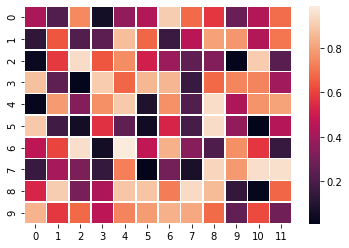

In [3]:
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data, linewidth=0.5)
plt.show()